In [4]:
#Name: Abel
#Date: 2021.08.11
#Purpose: to inquire about the effect of certain characteristics on price and to develop a predictive model on pricing based on current prices
#TODO: Update excel file to read from
#References: Kaggle Tutorials

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [33]:
#-----Changes entries in col to NaN that have a count of less than or equal to the threshold------#
def remove_rare_values_in (col, threshold, df): 
    value_counts = df[col].value_counts()  
    to_remove = value_counts[value_counts <= threshold].index
    print ('The following:', to_remove,'was removed in', col)
    df['Vehicle'].replace(to_remove, np.nan, inplace=True)

#df = df.dropna(subset=['Vehicle', 'Year', 'Mileage', 'Price', 'Color'], axis=0) #removes any NaN data; color is included to investigate the factor color
#df = df[df.Mileage < 150000]

#print (df.shape)  #after 'more cleaning'
#df = df.sort_values (by=['Price'], ascending=True)

In [34]:
# read the data, compile all into one DF
df1 = pd.concat(pd.read_excel('2021.10.01 Honda Civics (MLReady).xlsx', sheet_name=None), ignore_index=True) 
df3 = pd.concat(pd.read_excel('2021.08.10 Honda Civics (MLReady).xlsx', sheet_name=None), ignore_index=True) 
df3 = pd.concat(pd.read_excel('2021.08.16 Honda Civics (MLReady).xlsx', sheet_name=None), ignore_index=True) 
data = pd.concat ([df1, df2, df3], axis=0)
print ("before preprocessing, data shape: ", data.shape) #before 'more cleaning'

#Removes rows with missing target, seperate target from predictors
data.dropna(axis=0, subset=['Price'], inplace=True)
y = data.Price
X = data.drop(['Price'], axis = 1)

#Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Select categorical columns 
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype == "object"]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

print(X_train.head())


before preprocessing, data shape:  (451, 6)
     Vehicle   Color Location  Year  Mileage
65   Touring     red   Sisley  2018    33653
163       LX  silver  Parkway  2017    75452
163    Sport    blue   Sisley  2019    14736
80        EX   black    Maple  2018    99065
46      EX-L  silver  Midtown  2009   238903


In [35]:
#----------------Preparing preprocessing process------------------#
# Preprocessing for numerical data
numerical_transformer = SimpleImputer() #strategy='mean' by default

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

{50: 751.0535494365412, 100: 750.7342185163351, 150: 750.3241050609573, 200: 751.5312030107767, 250: 752.2790775622698, 300: 753.3644542187203, 350: 753.162329759118, 400: 752.9039857036147}


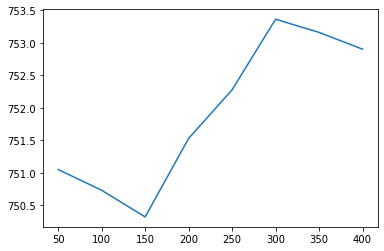

In [41]:
#----------------Finding optimal n_estimator for the RandomForestRegressor------------------#
results = {}
for est in range(50, 401, 50):
    # Define model
    model = RandomForestRegressor(n_estimators=est, random_state=1)

    # Bundle preprocessing and modeling code in a pipeline
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])
    # Replace this body with your own code
    scores = -1* cross_val_score(my_pipeline, X, y,
                              cv=3,
                              scoring='neg_mean_absolute_error')
    results [est] = scores.mean()
# Visualizing results
print (results)
%matplotlib inline
plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [42]:
#----------------Fitting with optimized n_estimator------------------#
model = RandomForestRegressor(n_estimators=150, random_state=1)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))
#print (X_train.head(20))

MAE: 783.9697813639036
